In [74]:
#imports
import numpy as np
import os
import cv2
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

from pylab import *

In [2]:
def file_to_xr(filepath: str, index: bool, altitude: str, channel: str):
    
    if index:
        arr = (cv2.imread(filepath, cv2.IMREAD_UNCHANGED).astype(np.float32))
        fname = 'index'
    else:
        arr = (cv2.imread(filepath, cv2.IMREAD_GRAYSCALE).astype(np.float32))
        fname = 'pixel'
    
    dim1 = arr.shape[0]
    dim2 = arr.shape[1]
    yrange = range(0,-1*dim1, -1) #not sure what to agree on for coords but putting (0,0) as top left and making y negative to stay cartesian
    xrange = range(0,dim2)
    test_xr = xr.DataArray(arr, coords={'altitude':'low','channel':channel, 'y': yrange,'x': xrange}, dims=["y", "x"], name=fname+'_'+altitude+'_'+channel)
    
    #cleaning
    if index:
        test_xr = test_xr.where(test_xr != -10000)

    test_xr = test_xr.to_dataset(name=fname+'-'+altitude+'-'+channel)
    return test_xr


# combine across channels?
#test_xr = test_xr.where(test_xr.any(dim = ['channel']) ) #make NaN when all zero across a channel (and altitude) to indicate black space

### Data Prep

In [3]:
#just hardcoding filepath for testing
lgi_file = r'C:\Users\Devan\Downloads\greenland\calibration_test\map3ads_mosaic_index\map3a_ds_transparent_reflectance_green.tif'
lgi = file_to_xr(lgi_file, True, 'low', 'green')
lri_file = r'C:\Users\Devan\Downloads\greenland\calibration_test\map3ads_mosaic_index\map3a_ds_transparent_reflectance_red.tif'
lri = file_to_xr(lri_file, True, 'low', 'red')
lrei_file = r'C:\Users\Devan\Downloads\greenland\calibration_test\map3ads_mosaic_index\map3a_ds_transparent_reflectance_red edge.tif'
lrei = file_to_xr(lrei_file, True, 'low', 'rededge')
lni_file = r'C:\Users\Devan\Downloads\greenland\calibration_test\map3ads_mosaic_index\map3a_ds_transparent_reflectance_nir.tif'
lni = file_to_xr(lni_file, True, 'low', 'nir')

In [4]:
#combine
index_full = xr.merge([lgi,lri,lrei,lni], compat='minimal')
#index_full
test = index_full.to_array(dim='newvar')
test = test.stack(yx=('y','x'))
test = test.transpose('yx','newvar')
test

<xarray.DataArray (yx: 105395016, newvar: 4)>
array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)
Coordinates:
    altitude  <U3 'low'
  * newvar    (newvar) object 'index-low-green' ... 'index-low-nir'
  * yx        (yx) object MultiIndex
  * y         (yx) int32 0 0 0 0 0 0 0 ... -9912 -9912 -9912 -9912 -9912 -9912
  * x         (yx) int32 0 1 2 3 4 5 6 ... 10626 10627 10628 10629 10630 10631

In [29]:
test_noNan = test.dropna(dim="yx", how="any")
test_noNan

<xarray.DataArray (yx: 76700208, newvar: 4)>
array([[0.09739731, 0.08870002, 0.06963062, 0.20270461],
       [0.09578427, 0.08915527, 0.06843036, 0.19211644],
       [0.09595562, 0.08917853, 0.07120589, 0.19209957],
       ...,
       [0.15955713, 0.15263496, 0.11878469, 0.26035714],
       [0.15742707, 0.15034595, 0.12410279, 0.26429585],
       [0.16128886, 0.14920476, 0.12657174, 0.26291996]], dtype=float32)
Coordinates:
    altitude  <U3 'low'
  * newvar    (newvar) object 'index-low-green' ... 'index-low-nir'
  * yx        (yx) object MultiIndex
  * y         (yx) int32 -1 -1 -1 -1 -1 -1 ... -9912 -9912 -9912 -9912 -9912
  * x         (yx) int32 5202 5203 5204 5205 5206 ... 2079 2080 2081 2082 2083

### Clustering

In [97]:
%%time
kmeans = KMeans(n_clusters=4, random_state=0, n_init=5)
kmeans.fit(test_noNan)
kmeans.cluster_centers_

CPU times: total: 40min 21s
Wall time: 12min 18s


array([[0.1062378 , 0.09497184, 0.08397585, 0.10963811],
       [0.33163452, 0.28950757, 0.24150428, 0.21356355],
       [0.21484056, 0.1896505 , 0.16156429, 0.16455756],
       [0.46366537, 0.39501035, 0.32368845, 0.2604545 ]], dtype=float32)

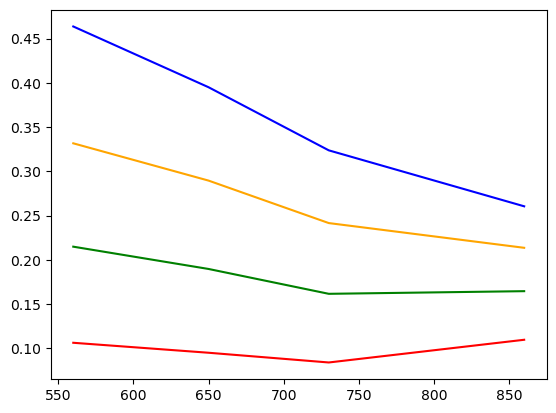

In [98]:
colors= ['blue','lightblue','green','yellow'] #default
colors= ['red','orange','green','blue'] #Spectral
sns.lineplot(x=[560,650,730,860], y=kmeans.cluster_centers_[0], color=colors[0])
sns.lineplot(x=[560,650,730,860], y=kmeans.cluster_centers_[1], color=colors[1])
sns.lineplot(x=[560,650,730,860], y=kmeans.cluster_centers_[2], color=colors[2])
sns.lineplot(x=[560,650,730,860], y=kmeans.cluster_centers_[3], color=colors[3]);

In [99]:
#add back
test_noNan_xr = test_noNan.to_dataset(name='test_noNan')
test_noNan_xr['test_noNan_labels']= (['yx'], kmeans.labels_)
test_noNan_xr

<xarray.Dataset>
Dimensions:            (newvar: 4, yx: 76700208)
Coordinates:
    altitude           <U3 'low'
  * newvar             (newvar) object 'index-low-green' ... 'index-low-nir'
  * yx                 (yx) object MultiIndex
  * y                  (yx) int32 -1 -1 -1 -1 -1 ... -9912 -9912 -9912 -9912
  * x                  (yx) int32 5202 5203 5204 5205 ... 2080 2081 2082 2083
Data variables:
    test_noNan         (yx, newvar) float32 0.0974 0.0887 ... 0.1266 0.2629
    test_noNan_labels  (yx) int32 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2

In [100]:
%%time
test_noNan_unstack = test_noNan_xr.test_noNan_labels.unstack('yx')
#del test_noNan_xr, test_noNan, index_full
test_noNan_unstack = test_noNan_unstack.sortby('x') #need to sort for plotting properly with imshow
test_noNan_unstack

CPU times: total: 13 s
Wall time: 13.4 s


<xarray.DataArray 'test_noNan_labels' (y: 9912, x: 10631)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y         (y) int32 -1 -2 -3 -4 -5 -6 ... -9908 -9909 -9910 -9911 -9912
  * x         (x) int32 1 2 3 4 5 6 7 ... 10626 10627 10628 10629 10630 10631
    altitude  <U3 'low'

C:\Users\Devan\AppData\Local\Temp\ipykernel_16364\2665645211.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral', 4)


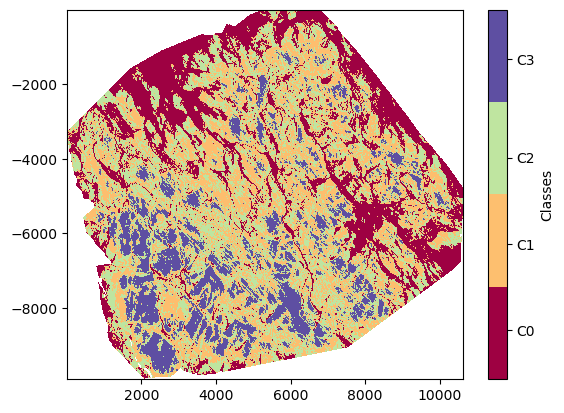

In [101]:
cmap = cm.get_cmap('Spectral', 4)    

if True:
    plt.imshow(test_noNan_unstack.data
               , extent=[test_noNan_unstack.x.min(), test_noNan_unstack.x.max()
                       , test_noNan_unstack.y.min(), test_noNan_unstack.y.max() ], origin="upper"
               ,cmap=cmap
              )

#plt.imshow(test_noNan_unstack.data)

cbar2 = plt.colorbar()
cbar2.set_label('Classes')
cbar2.set_ticks([0.4,1.1,1.8,2.6])  
cbar2.set_ticklabels(['C0','C1','C2','C3'])

In [102]:
#percetages of each class
unique, counts = np.unique(test_noNan_unstack.data, return_counts=True)
counts_dict = dict(zip(unique, counts))
counts_dict

{0.0: 20893743, 1.0: 20933480, 2.0: 22956042, 3.0: 11916943, nan: 28674264}

In [103]:
total = 0
total_nonan = 0
for x in counts_dict.items():
    total += x[1]
    if x[0] != x[0]: #if nan
        pass
    else:
        total_nonan += x[1]
        
for x in counts_dict.items():
    if x[0] != x[0]: #if nan
        print(f'\nNull Data - {x[1]:,} - {(x[1]/total*100).round(1)}%')
    else:
        print(f'Class {int(x[0])} - {x[1]:,} - {(x[1]/total_nonan*100).round(1)}%')

Class 0 - 20,893,743 - 27.2%
Class 1 - 20,933,480 - 27.3%
Class 2 - 22,956,042 - 29.9%
Class 3 - 11,916,943 - 15.5%

Null Data - 28,674,264 - 27.2%


### Unused

CPU times: total: 1min 31s
Wall time: 1min 31s


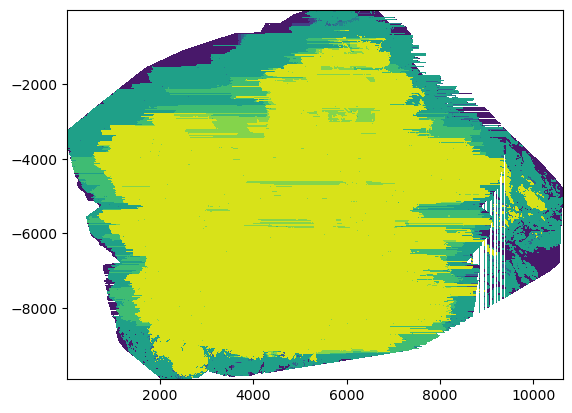

In [9]:
%%time
#plt.contourf(test_noNan_unstack.x,test_noNan_unstack.y,test_noNan_unstack.data) 